In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import layers, models, optimizers
from keras.callbacks import EarlyStopping

from sklearn.metrics import classification_report

In [2]:
def show_result(test1):
    # Mostrar los resultados
    fig, ax = plt.subplots(2,1,figsize=(6,3))
    ax[0].plot(test1.history['loss'], color='b', label="Training loss")
    ax[0].plot(test1.history['val_loss'], color='r', label="validation loss")
    legend = ax[0].legend(loc='best', shadow=True)
    ax[0].grid()

    ax[1].plot(test1.history['accuracy'], color='b', label="Training accuracy")
    ax[1].plot(test1.history['val_accuracy'], color='r',label="Validation accuracy")
    ax[1].set_ylim(0,1)
    legend = ax[1].legend(loc='best', shadow=True)
    ax[1].grid()

    plt.tight_layout()
    plt.show()

In [3]:
# Cargar los datasets
feat_train = np.load('../0_training_datasets/feat_train.npy')
label_train = np.load('../0_training_datasets/label_train.npy')
feat_val = np.load('../0_training_datasets/feat_val.npy')
label_val = np.load('../0_training_datasets/label_val.npy')


In [5]:
## Estructura 
### Alexnet
inputs = layers.Input(shape=(128, 141, 1))
# Bloque 1
x = layers.Conv2D(96, (11, 11), strides=4, activation='relu', padding='valid')(inputs)
x = layers.MaxPooling2D((3, 3), strides=2)(x)
# Bloque 2
x = layers.Conv2D(256, (5, 5), strides=1, activation='relu', padding='same')(x)
x = layers.MaxPooling2D((3, 3), strides=2)(x)
# Bloque 3
x = layers.Conv2D(384, (3, 3), strides=1, activation='relu', padding='same')(x)
x = layers.Conv2D(384, (3, 3), strides=1, activation='relu', padding='same')(x)
x = layers.Conv2D(256, (3, 3), strides=1, activation='relu', padding='same')(x)
x = layers.MaxPooling2D((3, 3), strides=2)(x)

# Clasificador
x = layers.Flatten()(x)
x = layers.Dense(4096, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(4096, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(4, activation='softmax')(x)

# Crear el modelo
AlexNet = models.Model(inputs, outputs, name="AlexNet")
# Resumen del modelo
AlexNet.summary()

Model: "AlexNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 141, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 30, 33, 96)     │        11,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 16, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 16, 256)    │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 6, 7, 384)      │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 7, 384)      │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 6, 7, 256)      │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │     6,295,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │        16,388 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,817,220 (102.30 MB)

 Trainable params: 26,817,220 (102.30 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Define el optimizador y compila el modelo
optimizer = optimizers.Adam(learning_rate=0.0001)
AlexNet.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

In [7]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [8]:
# Entrena el modelo
history = AlexNet.fit(feat_train, label_train,
                   batch_size=32, epochs=50,
                   validation_data=(feat_val, label_val),
                   verbose=1,
                   callbacks=[early_stopping]
                   )

test_loss, test_acc = AlexNet.evaluate(feat_val, label_val, verbose=2)


Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 262ms/step - accuracy: 0.2903 - loss: 1.7027 - val_accuracy: 0.5072 - val_loss: 1.2021
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 245ms/step - accuracy: 0.4389 - loss: 1.2187 - val_accuracy: 0.7101 - val_loss: 0.7641
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 238ms/step - accuracy: 0.6763 - loss: 0.8023 - val_accuracy: 0.7681 - val_loss: 0.4936
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 240ms/step - accuracy: 0.7954 - loss: 0.5393 - val_accuracy: 0.8406 - val_loss: 0.4675
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 231ms/step - accuracy: 0.8481 - loss: 0.4659 - val_accuracy: 0.8116 - val_loss: 0.4871
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 235ms/step - accuracy: 0.9165 - loss: 0.2409 - val_accuracy: 0.8696 - val_loss: 0.3084
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 232ms/step - accuracy: 0.9282 - loss: 0.2594 - val_accuracy: 0.8696 - val_loss: 0.7011
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 232ms/step - accuracy: 0.9042 - loss: 0.2473 - val_accuracy: 0.

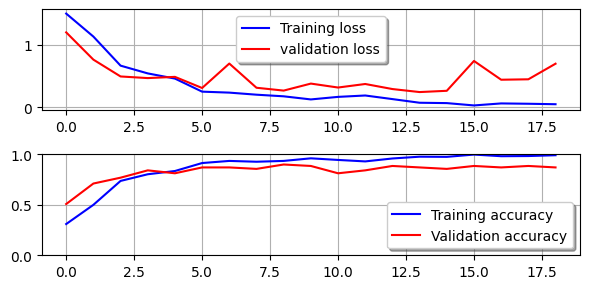

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
              precision    recall  f1-score   support

     Paisaje       0.75      0.92      0.83        13
       Avion       0.86      0.95      0.90        19
       Motor       0.87      0.76      0.81        17
       Voces       1.00      0.85      0.92        20

    accuracy                           0.87        69
   macro avg       0.87      0.87      0.86        69
weighted avg       0.88      0.87      0.87        69



In [10]:
show_result(history)
# Haz predicciones en el conjunto de validación
y_pred = AlexNet.predict(feat_val)

# Convierte las predicciones a etiquetas de clase
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(label_val, axis=1)

# Calcula precision, recall, y F1-score
report = classification_report(y_true_classes, y_pred_classes, target_names=['Paisaje', 'Avion', 'Motor', 'Voces'])
print(report)

In [11]:
# AlexNet.save("AlexNet_b.keras")